## 导入依赖库
pytorch实现

In [17]:
import sys
import time
import cv2
import os
from PIL import Image
import zipfile

import torch
from torch import optim
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torchvision import transforms, datasets

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from src.model import EfficientNet

## 定义全局变量


In [18]:
pub_para = {
    "data_zip_path" : "../rodata/dp_src/fgvc-aircraft-2013b.zip",
    "train": "./src/data/train",
    "test": "./src/data/test",

    "is_log_handle": True,
    "log_file": "./src/logs/EfficientNetb4.log",

    "model": "efficientnet-b4",
    "from_pretrained": True,
    "num_classes": 100,

    "batch_size": 15,
    "EPOCH": 100,
    "lr": 1e-3,

    "img_path_list": ['DR-400/1423710.jpg', 'DR-400/1276588.jpg', 'DR-400/2231688.jpg',
                      'DHC-1/2165387.jpg', 'DHC-1/1768028.jpg', 'DHC-1/1382206.jpg',
                      'ATR-72/1022616.jpg', 'ATR-72/0483586.jpg', 'ATR-72/0136180.jpg'],
    "cam_out_dir": './src/cam',
    "cam_pre_dir":"./src/pretrained/cam"
    }

## 日志设置


In [3]:
if pub_para["is_log_handle"]:
    sys.stdout = open(pub_para["log_file"], "a")
    # 程序开始时间
    start_time = time.strftime("%Y-%m-%d %H:%M:S", time.localtime(time.time()))
    print(f"{start_time}:Programing Start...")

# 将数据集解压到本地

In [4]:
zip_path = pub_para['data_zip_path']
if zipfile.is_zipfile(zip_path):
    zip_file = zipfile.ZipFile(zip_path)
    zip_list = zip_file.namelist()
    for f in zip_list:
        zip_file.extract(f, "./src")
else:
    print('can not find fgvc-aircraft-2013b.zip...')

## 读取数据
对数据集进行预处理，数据集的构成为train和test两个，对train数据集进行随机仿射、水平翻转等数据增强

In [5]:
input_size = EfficientNet.get_image_size(pub_para['model'])
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),
        transforms.RandomRotation(180),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]),
    'test': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    }
image_datasets = {x: datasets.ImageFolder(pub_para[x],
                                          data_transforms[x]) for x in ['train', 'test']}
dataloader_dict = {x: DataLoader(image_datasets[x],
                                 batch_size=pub_para['batch_size'],
                                 shuffle=True,
                                 num_workers=0) for x in ['train', 'test']}

## 模型训练
优化器采用Adam随机优化

In [ ]:
def train():
    if pub_para["from_pretrained"]:
        # 导入原始预训练模型
        net = EfficientNet.from_pretrained(pub_para['model'])
    else:
        # 导入中断处的权重信息
        net = EfficientNet.from_name(pub_para['model'])
        net.load_state_dict(torch.load('./src/logs/b4/weights_99.pth'))
    use_gpu = torch.cuda.is_available()
    if use_gpu:
        net = net.cuda()
    net._fc.out_features = pub_para['num_classes']
    # 定义优化器
    params_to_update = []
    for name, param in net.named_parameters():
        params_to_update.append(param)
    optimizer = optim.Adam(params_to_update,
                           lr=pub_para['lr'],
                           betas=(0.9, 0.999),
                           eps=1e-9)
    loss_func = torch.nn.CrossEntropyLoss()
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                     mode='max',
                                                     factor=0.7,
                                                     patience=3,
                                                     verbose=True)
    acc_list = []
    loss_list = []
    for epoch in range(pub_para['EPOCH']):
        running_loss = 0.0
        for step, data in enumerate(dataloader_dict['train']):
            # 获取数据并放置于GPU或CPU中
            inputs, labels = data
            if(use_gpu):
                inputs = inputs.cuda()
                labels = labels.cuda()
            else:
                inputs, labels = Variable(inputs), Variable(labels)
            # 前向计算、损失计算、梯度计算、误差反向传播、梯度更新
            outputs = net.forward(inputs)
            loss = loss_func(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # 打印状态信息
            running_loss += loss.item()
            if step % 5 == 4:    # 每5批次打印一次
                print('[epoch:%d, step:%5d] loss: %.3f' %(epoch + 1, step + 1, running_loss /1000), flush=True)
                loss_list.append(running_loss)
                running_loss = 0.0
        # 每个epoch结束后保存权重
        torch.save(net.state_dict(), './src/logs/b4/weights_%d.pth' % (epoch))
        # #######验证集精度#######
        correct = 0
        total = 0
        with torch.no_grad():
            # 不计算梯度，节省时间
            for (images, labels) in dataloader_dict['test']:
                images = images.cuda()
                labels = labels.cuda()
                outputs = net(images)
                numbers, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        acc = 100 * correct / total
        scheduler.step(acc)
        print('Accuracy of the network on the val images: %d %%' % acc)
        acc_list.append(acc)
    # 保存损失和精度
    acc_frame = pd.DataFrame({"accuracy": acc_list})
    acc_frame. to_csv("./src/logs/acc.csv", index = False)
    loss_frame = pd.DataFrame({"loss": loss_list})
    loss_frame. to_csv("./src/logs/loss.csv", index = False)
    print('Finished Training')
train()

## 损失和精度曲线

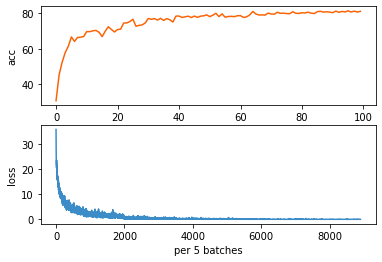

In [23]:
acc_list = pd.read_csv("./src/pretrained/acc.csv")
loss_list = pd.read_csv("./src/pretrained/loss.csv")

plt.figure('loss and acc')
plt.subplot(211)
plt.plot(acc_list, color=(250/255, 100/255, 5/255),label='acc') 
plt.xlabel('epochs')
plt.ylabel('acc')

plt.subplot(212)
plt.plot(loss_list, color=(60/255,140/255,200/255),label='loss')
plt.xlabel('per 5 batches')
plt.ylabel('loss')

plt.show()

# grad-cam 生成

In [22]:
out_dir = pub_para['cam_out_dir']
class_list = []
img_name_list = []

# 图片预处理
def img_preprocess(img_in):
    img = img_in.copy()
    img = img[:, :, ::-1]  # cv2读入的图片通道是BGR，调整为RGB
    img = np.ascontiguousarray(img)  # 将内存内不连续储存的数组转为连续储存
    PIL_img = Image.fromarray(img)
    transform = transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    img = transform(PIL_img)
    img = img.unsqueeze(0)# 增加batch通道
    return img

def backward_hook(module, grad_in, grad_out):
    grad_block.append(grad_out[0].detach())

def forward_hook(module, input, output):
    fmap_block.append(output)

def cam_show_img(img_name, img, feature_map, grads, out_dir):
    H, W, _ = img.shape
    cam = np.zeros(feature_map.shape[1:], dtype=np.float32)
    grads = grads.reshape([grads.shape[0], -1])
    weights = np.mean(grads, axis=1)
    for i, w in enumerate(weights):
        cam += w*feature_map[i,:,:]
    cam = np.maximum(cam, 0)
    cam = cam / cam.max()
    cam = cv2.resize(cam, (W, H))

    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    cam_img = 0.3*heatmap + 0.7*img

    path_cam_img = os.path.join(out_dir, f"cam_{img_name}")
    cv2.imwrite(path_cam_img, cam_img)

for img_path in pub_para['img_path_list']:
    img_name = img_path.split('/')[-1]
    class_name = img_path.split('/')[-2]
    class_list.append(class_name)
    img_name_list.append(img_name)
    img_path = os.path.join(pub_para['test'], img_path)

    # 存放特征图和梯度
    fmap_block = []
    grad_block = []

    # 图片读取，预处理
    img = cv2.imread(img_path)
    img_input = img_preprocess(img)

    # 加载训练模型
    net = EfficientNet.from_name(pub_para['model'])
    net.load_state_dict(torch.load('./src/pretrained/weights_99.pth'))
    net.eval()

    # 注册hook
    net._blocks[-1].register_forward_hook(forward_hook)
    net._blocks[-1].register_backward_hook(backward_hook)

    # 前向传播
    output = net(img_input)
    idx = np.argmax(output.cpu().data.numpy())

    # 预测结果
    class_idx = image_datasets['test'].class_to_idx
    class_map = {}
    for key, val in class_idx.items():
        class_map[val] = key
    print(f"predict:     {class_map[idx]}")

    # 反向传播
    net.zero_grad()
    class_loss = output[0, idx]
    class_loss.backward()

    # 生成grad-cam
    grads_val = grad_block[0].cpu().data.numpy().squeeze()
    fmap = fmap_block[0].cpu().data.numpy().squeeze()

    # 保存
    cam_show_img(img_name, img, fmap, grads_val, out_dir)

# 打印grad-cam图片

<function matplotlib.pyplot.show(close=None, block=None)>

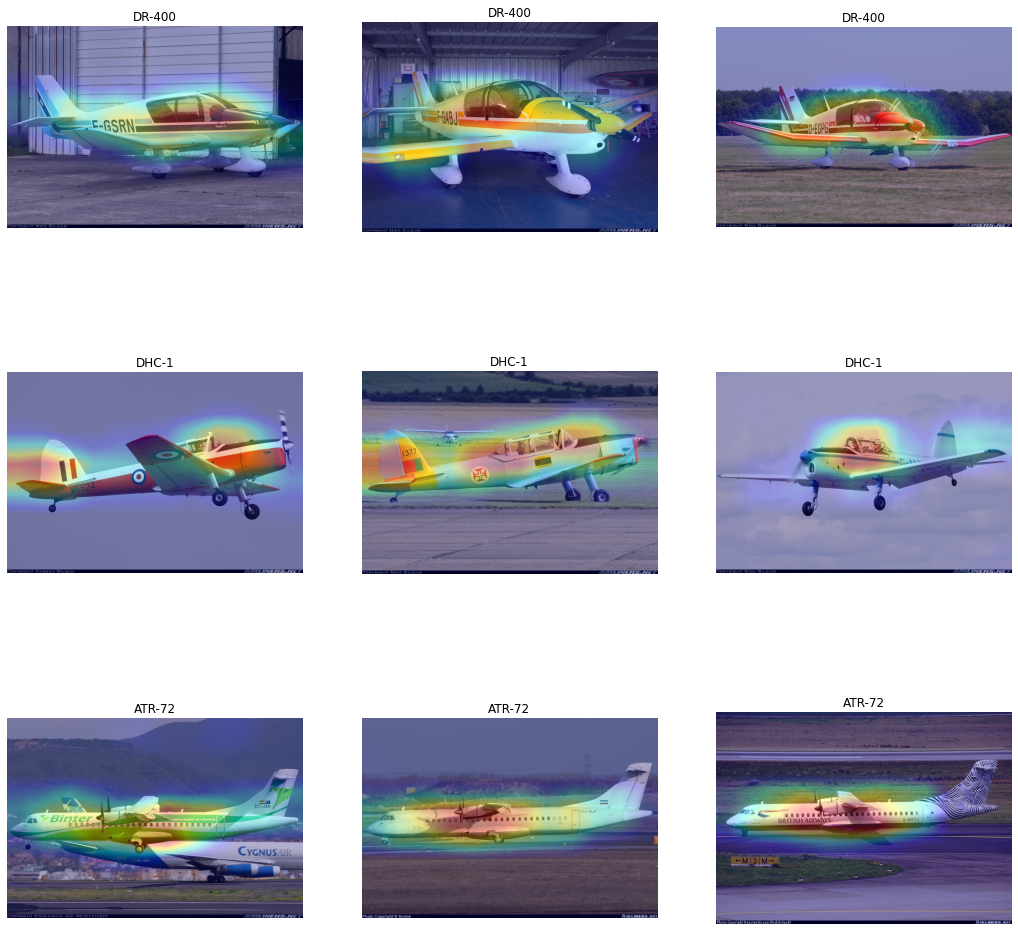

In [20]:
img_name_list = []
class_list = []
for img_path in pub_para['img_path_list']:
    img_name = img_path.split('/')[-1]
    img_name_list.append(img_name)
    class_name = img_path.split('/')[-2]
    class_list.append(class_name)
    
plt.figure(figsize=(18, 18))

for i, img_name in enumerate(img_name_list):
    cam_img = plt.imread(os.path.join(pub_para['cam_pre_dir'], f"cam_{img_name}"))
    t = i+1
    plt.subplot(3, 3, t)
    plt.axis('off')
    plt.title(class_list[i])
    plt.imshow(cam_img)
plt.show